# Yelp benchmark

Using Yelp reviews to test the differnce between simple term document matrix apporach and finetuned BERT model

In [61]:
import pandas as pd

# plotting stuff
import seaborn as sns
import matplotlib.pyplot as plt
from PIL import Image
from plotnine import *
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import pyLDAvis
import pyLDAvis.gensim  # don't skip this

# machine leqarning 
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer
import xgboost as xgb
from sklearn.linear_model import LogisticRegression
import xgboost as xgb

# metrics
from sklearn.metrics import roc_auc_score, accuracy_score

# language
import spacy
nlp = spacy.load("en")

## Import data

Import csv files downloaded from [here](https://course.fast.ai/datasets)

In [2]:
train_df = pd.read_csv('data/train.csv', header=None, names=['target', 'text'])
test_df = pd.read_csv('data/test.csv', header=None,  names=['target', 'text'])

The target is coded as 1 (bad) or 2 (good). We are going to recode into 0 is bad and 1 is good

In [3]:
train_df = (
    train_df
    .assign(target  = train_df.target -1)
)
test_df = (
    test_df
    .assign(target  = test_df.target -1)
)

In [4]:
#### show some records
pd.options.display.max_colwidth = 1000
train_df.sample(5)

,target,text
176699,1,"This buffet is okay. You can't expect too much from a brunch buffet that is $15 regular price including bottomless mimosas. When we used the hotel stay coupons, and out players card, we only ended up paying like $8 with tax. Taking that into consideration, you get a lot of bang for your buck. \n\nThe food is average of course, but it was clean, bright, and covered all the basic buffet options. \n\nSurprisingly, I had some pretty good steamed cabbage. I mean, it was on the level of southern grandma Sunday dinner. I know, crazy right? I even went and complimented the chefs behind the buffet glass. Hey, drink enough mimosas, and you are throwing compliments everywhere! \n\nWould I go back to the Garden Buffet at the South Point? Of course, especially since they give 50% off coupons. It's totally worth it if you take advantage of the bottomless mimosas."
122884,0,"What a crappy place, surrounded by crappy people to have to get a health card. CLOSED for lunch as we arrived... Are you kidding me? What a racket for unnecessary government fees...."
394839,1,"This is not the Buck's I remember from my days living in Madison! Nice, nice, nice. Great drinks. Real glasses. Fun place to waste some time before a game at the Kohl Center. \nI did not get food but the plates I saw looked good!"
415516,0,"Came here for a very special occasion. The prices are high and it's in the Wynn. My expectations were high - as they should be for a place like this. Unfortunately, it did not meet my expectations. One of the worst $120+ meals I've had.\n\nThe best part of the meal was the Basket of bread - Keep it coming!\nThe show was good, there's a show every 30 minutes. We watched 3 of them and they were all different.\n\nCons:\n* Halibut - Way too dry. Had to keep drinking water to eat 1/2 the meal.\n* Lobster Bisque - Way too salty. Again, water saved the night.\n* Swordfish - Tasteless and boring seasoning.\n* Wine pair - Sucked, the servers didn't have a clue on what was good to pair the dishes with. We sent back the wine twice!\n* Slow service"
330592,1,"We really enjoy this sushi spot close to home, never a wait, good rolls, great ginger dressing salad. Favorite sushi spot for lunch or dinner with my husband or the family!!"


## Text preparation

In [5]:
def clean_review(x):
    doc = nlp(x)
    tokens = [token.text for token in doc if (not token.is_punct) & (not token.is_stop)]
    return " ".join(tokens)

In [7]:
review_sample = train_df.sample(20000)
review_sample = (
    review_sample
    .assign(
        cleaned_review = review_sample.text.apply(clean_review)
    )
)  

In [8]:
review_sample.to_pickle("reviews.pck")

In [9]:
### overview of the target
review_sample.target.value_counts()

1    10008
0     9992
Name: target, dtype: int64

## Machine learning models

In [16]:
### using scikit learn count vectorizer
cv = CountVectorizer(ngram_range=(1,2))
cv.fit(review_sample.cleaned_review)
X = cv.transform(review_sample.cleaned_review)
target = review_sample.target

X_train, X_val, y_train, y_val = train_test_split(
    X, target, train_size = 0.75
)

/opt/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:2179: FutureWarning: From version 0.21, test_size will always complement train_size unless both are specified.
  FutureWarning)


### Logistic regrssion

In [18]:
for c in [0.01, 0.05, 0.25, 0.5, 0.75, 0.95, 1]:
    lr = LogisticRegression(C=c)
    lr.fit(X_train, y_train)
    print (
        "Accuracy for C=%s: %s" 
        % (c, accuracy_score(y_val, lr.predict(X_val)))
    )

/opt/anaconda3/lib/python3.7/site-packages/sklearn/linear_model/logistic.py:433: FutureWarning: Default solver will be changed to 'lbfgs' in 0.22. Specify a solver to silence this warning.
  FutureWarning)


Accuracy for C=0.01: 0.886
Accuracy for C=0.05: 0.8936
Accuracy for C=0.25: 0.8972
Accuracy for C=0.5: 0.8968
Accuracy for C=0.75: 0.8958
Accuracy for C=0.95: 0.8956
Accuracy for C=1: 0.8956


In [19]:
final_model = LogisticRegression(C=0.25)
final_model.fit(X_train, y_train)

LogisticRegression(C=0.25, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=None, solver='warn',
          tol=0.0001, verbose=0, warm_start=False)

In [44]:
### area under roc and
y_pred = final_model.predict_proba(X_val)
print(
    roc_auc_score(y_val, y_pred[:,1])
)

0.9568841266102771


In [20]:
#### The best and worst words......
wordcoef = pd.DataFrame({
    "word": cv.get_feature_names(),
    "coef":  final_model.coef_[0]
})

print("Number of coefficients", wordcoef.shape)
print("Number of nonzero coefficients", wordcoef.query('(coef < 0) | (coef > 0)'). shape)

wordcoef.sort_values(by="coef", inplace = True)

Number of coefficients (790782, 2)
Number of nonzero coefficients (624904, 2)


In [21]:
wordcoef.head(15)

,word,coef
323506,horrible,-1.541260
781282,worst,-1.523703
414486,mediocre,-1.412504
73217,bland,-1.332379
695165,terrible,-1.316065
530777,poor,-1.261132
493251,overpriced,-1.222132
190845,disappointing,-1.188984
588842,rude,-1.133829
205579,dry,-1.028558


In [22]:
wordcoef.tail(15)

,word,coef
789589,yummy,0.900728
689986,tasty,0.930016
218396,enjoyed,0.933778
241511,favorite,0.944853
64777,best,1.038862
294253,great,1.172549
777013,wonderful,1.182611
396187,loved,1.187642
394900,love,1.224099
238926,fantastic,1.232831


### xgboost

In [53]:
dtrain = xgb.DMatrix(
    X_train, 
    label = y_train, 
    feature_names=cv.get_feature_names()
)
dtest = xgb.DMatrix(
    X_val, 
    label = y_val,
    feature_names=cv.get_feature_names()
)

param = {
    'max_depth':15,
    'objective':'binary:logistic'
}
watchlist = [(dtest, 'eval'), (dtrain, 'train')]
num_round = 50
word_xgb_model = xgb.train(param, dtrain, num_round) #, watchlist)

/opt/anaconda3/lib/python3.7/site-packages/xgboost/core.py:587: FutureWarning: Series.base is deprecated and will be removed in a future version
  if getattr(data, 'base', None) is not None and \


In [54]:
### area under roc and accuracy metrics on test set
y_pred_xgb = word_xgb_model.predict(dtest)

In [55]:
y_pred_xgb

array([0.04864689, 0.12026416, 0.00245252, ..., 0.07826545, 0.88711256,
       0.98422134], dtype=float32)

In [56]:
### area under roc and
print(
    roc_auc_score(y_val, y_pred_xgb)
)

0.9415588135150634


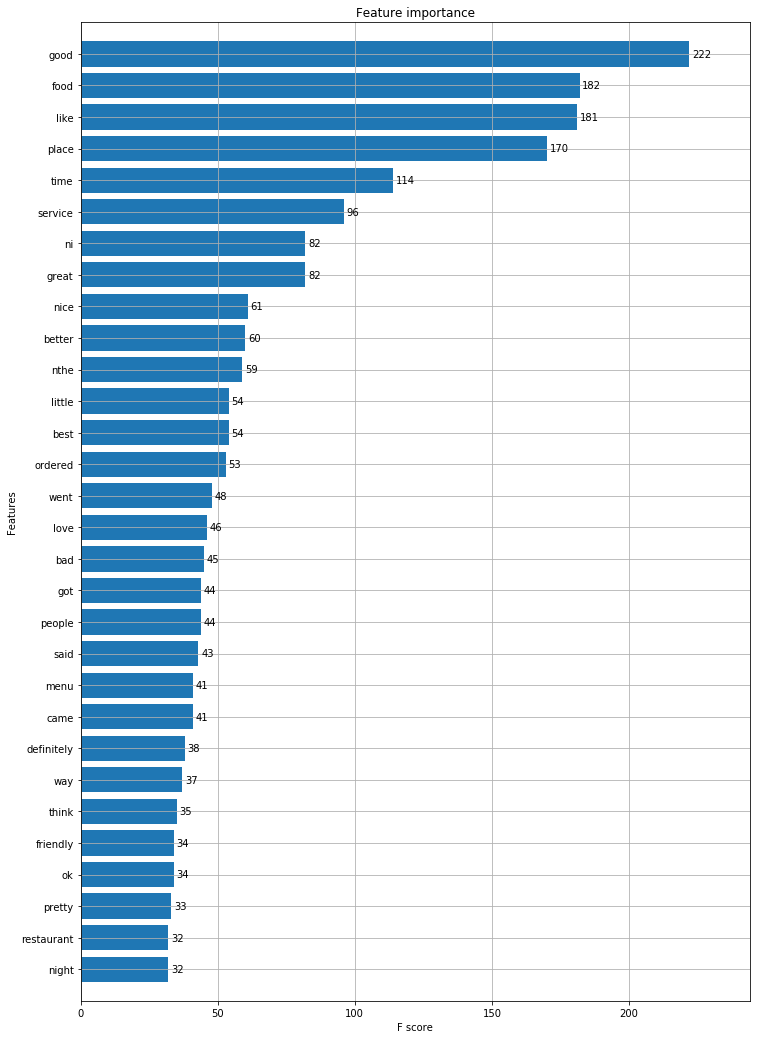

In [62]:
fig, ax = plt.subplots(figsize=(12,18))
xgb.plot_importance(word_xgb_model, max_num_features=30, height=0.8, ax=ax)
plt.show()